<a href="https://colab.research.google.com/github/eljimenezj/CM0868--Estadistica-Multivariada-Avanzada/blob/master/01_Clasificaci%C3%B3n_de_imagenes_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadistica Multivariada - Clasificación de imagenes con modelos de Machine Learning en `sklearn`

Este libro contiene un estudio de de clasificación de imagenes utilizando la libreria `sklearn` de python. Esto libro hace parte del proyecto final del curso de Estadistica Multivariada Avanzanda de la Maestría de Ciencia de Datos.

Los integrantes de este trabajo:

* Jorge Luis Renteria Roa
* Edgar Leandro Jimenez Jaimes


Vamos a instalar las librerias necesarias para la ejecución de este libro

In [1]:
# Importación libreria

import re
import glob
import time
import imutils
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from skimage.io import imread
from collections import Counter
import matplotlib.pyplot as plt

from keras.preprocessing import image 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, plot_roc_curve,roc_curve

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)

Using TensorFlow backend.


## Lectura y estructuración de pipeline

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Repo de Imagenes
path= '/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/datalake_edgar'

# Listas de almacenamiento
image_list=[]
tags=[]
imagemath=[]
train_img = []

# Recorrido de los archivos de imagenes
for filename in glob.glob(path+'/*'): 
  img = imread(filename)                   # Lee la imagen del datalake
  img_pred = cv.resize(img, (400, 400))    # Todas las imagenes quedan de 400 pixeles por 400 pixeles 
  img_pred = img_pred / 255                # Normalizando la imagen, cada pixel toma valores de 0 a 255.
  train_img.append(img_pred)               # Anexar la imagen a una lista
  tags.append(re.sub(path,'',filename)[1]) # Label
  image_list.append(filename)

In [4]:
# Creación de tags de las imagenes
X = np.array(train_img)
y = np.array(tags)

df = pd.DataFrame()
df['Nombre']=list(image_list)
df['Tag']=list(tags)
df['Matriz']=list(train_img)

df.head(3)                   # Mostramos los primero registro

,Nombre,Tag,Matriz
0,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.8470588235294118, 0.6666666666666666, 0.5..."
1,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.38823529411764707, 0.30980392156862746, 0..."
2,/content/drive/My Drive/Estadistica Multivaria...,1,"[[[0.6705882352941176, 0.4588235294117647, 0.3..."


In [5]:
# Observemos el numero de registros por clases
print(sorted(Counter(y).items()))

[('1', 150), ('2', 155)]


## Reshape y partición de datos en Train, Validation y Test

Redefiniciòn de dimensión de los arrays para entrenamiento con `sklearn`

In [6]:
# Para entrenar modelos clásicos necesitamos redefinir la dimensión de X

print("La dimensión de X que contiene las imagenes", X.shape)
 
x = np.array(train_img)
nsamples, nx, ny,channels = x.shape                    # Extracción de dimnesiónes originales
x_resh = x.reshape((nsamples,nx*ny*channels))          # Redimensionamiento

print("La nueva dimensión de X que contiene las imagenes", x_resh.shape)

La dimensión de X que contiene las imagenes (305, 400, 400, 3)
La nueva dimensión de X que contiene las imagenes (305, 480000)



La partición de los datos para el entrenamiento de los modelos se realiza en los siguiente 3 conjuntos y porcentajes:

* Train (60%)
* Validation (20%)
* Test (20%)

In [0]:
y = [int(i)-1 for i in list(y)]              # Tag de salida para que sea 0 y 1

In [0]:
# Partición de train
X_train, X_val1, y_train, y_val1 = train_test_split(x_resh, y,
                                                    stratify=y, 
                                                    test_size=0.40,  random_state = 42)

In [0]:
# Partición validación y test
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1,
                                                    stratify=y_val1, 
                                                    test_size=0.5,  random_state = 42)

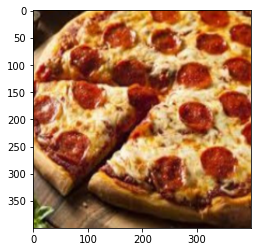

In [10]:
# Observemos un ejemplo de pizza peperoni
plt.imshow(X_train[10].reshape((400, 400, 3)))
plt.show()

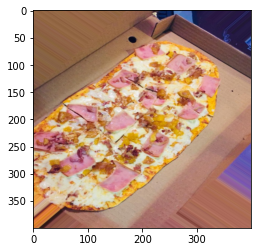

In [11]:
# Observemos un ejemplo de pizza  hawaina 
plt.imshow(X_train[4].reshape((400, 400, 3)))
plt.show()

# Clasificación de imagenes utilizando utilizando `sklearn`

Para esto utilizaremos los 3 modelos propuestos en clase:

1. Regresión Logistica
2. Random Forest
3. GradientBoosting

## Modelo 1 - Regresión Logistica

### Entrenamiento del modelo con parametros por defecto de libreria

In [12]:
model_rgl=LogisticRegression()                   # Instanciamos el modelo de regresión    
model_rgl.fit(X_train,y_train)                                   # Entrenamos el modelo con valores por defecto

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


### Metricas de clasificación con entrenamiento inicial

In [13]:
## Metrica Accuracy en train, val y test,

print('El desempeño de la regresion en train es de', accuracy_score(y_train, model_rgl.predict(X_train)))

# Desempeño en val
print('El desempeño de la regresion en validacion es de', accuracy_score(y_val, model_rgl.predict(X_val)))

# Desempeño en test 
print('El desempeño de la regresion en test es de', accuracy_score(y_test, model_rgl.predict(X_test)))

El desempeño de la regresion en train es de 1.0
El desempeño de la regresion en validacion es de 0.819672131147541
El desempeño de la regresion en test es de 0.8524590163934426


              precision    recall  f1-score   support

           0       0.88      0.73      0.80        30
           1       0.78      0.90      0.84        31

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.83      0.82      0.82        61



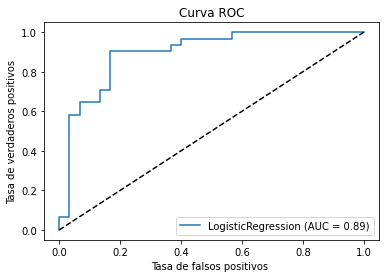

In [14]:
## Precision, Recall, F1-SCORE, y curva ROC en validation

print(classification_report(y_val, model_rgl.predict(X_val)))             # Revisamos metricas

# Graficamos curva ROC
plot_roc_curve(model_rgl, X_val, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos ')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()
plt.show()

### Óptimización de hipeparametros y revisión de metricas luego de optimizar

In [0]:
grid={"C":np.logspace(-3,3,7),               
      "penalty":["l1","l2"]}

model_rgl2=GridSearchCV(model_rgl,grid,cv=5, scoring = 'accuracy')

In [0]:
model_rgl2.fit(X_train,y_train)

### Metricas de clasificación despues de optimización 

In [0]:
# Desempeño en accuracy entrenamiento
print('El desempeño de la regresion en train es de', accuracy_score(y_train, model_rgl2.predict(X_train)))

# Desempeño en val
print('El desempeño de la regresion en validacion es de', accuracy_score(y_val, model_rgl2.predict(X_val)))

# Desempeño en test 
print('El desempeño de la regresion en test es de', accuracy_score(y_test, model_rgl2.predict(X_test)))

In [0]:
# Precision, recall y f1-scores en validation
print(classification_report(y_val, model_rgl2.predict(X_val))) 

In [0]:
# Pendiente entrenar con train + validation y testear

## Modelo 2 - Random Forest

### Entrenamiento del modelo con parametros por defecto de libreria

In [15]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)  # Instanciamos el modelo 

random_forest.fit(X_train, y_train)                                    # Entrenamos el modelo

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Metricas de clasificación con entrenamiento inicial

In [16]:
## Metrica Accuracy en train, val y test,

# Desempeño en entrenamiento
print('El desempeño del random en train es de', accuracy_score(y_train, random_forest.predict(X_train)))

# Desempeño en val
print('El desempeño del random en validacion es de', accuracy_score(y_val, random_forest.predict(X_val)))

# Desempeño en test 
print('El desempeño del random en test es de', accuracy_score(y_test, random_forest.predict(X_test)))

El desempeño del random en train es de 1.0
El desempeño del random en validacion es de 0.8032786885245902
El desempeño del random en test es de 0.8852459016393442


              precision    recall  f1-score   support

           0       0.85      0.73      0.79        30
           1       0.77      0.87      0.82        31

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



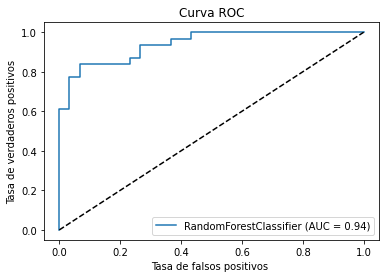

In [17]:
## Precision, Recall, F1-SCORE, y curva ROC en validation

print(classification_report(y_val, random_forest.predict(X_val)))             # Revisamos metricas

# Graficamos curva ROC
plot_roc_curve(random_forest, X_val, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos ')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()
plt.show()

### Óptimización de hipeparametros y revisión de metricas luego de optimizar

Establecemos los valores de los hiperparametros de busqueda del RandomForest

In [0]:
param_grid = {'n_estimators': [150,250,300],    # Aumentamos el numero de estimadores
              'max_features': ['sqrt', 'log2'], # Intetamos reducir el numero de features a traves de estas funciones  
              'max_depth':[5,8,10],
              'criterion':['gini', 'entropy']}

model_rf = GridSearchCV(estimator=random_forest, 
                        param_grid=param_grid, cv= 5, scoring = 'accuracy',
                        n_jobs=-1)

In [0]:
model_rf.fit(X_train, y_train)                  # Ajustamos y optimzamos hiperparametros con el conjunto de train 

In [0]:
model_rf.best_estimator_

### Metricas de clasificación despues de optimización 

In [0]:
# Desempeño en accuracy entrenamiento
print('El desempeño del random en train es de', accuracy_score(y_train, model_rf.predict(X_train)))

# Desempeño en val
print('El desempeño del random en validacion es de', accuracy_score(y_val, model_rf.predict(X_val)))

# Desempeño en test 
print('El desempeño del random en test es de', accuracy_score(y_test, model_rf.predict(X_test)))

In [0]:
# Precision, recall y f1-scores en validation
print(classification_report(y_val, model_rf.predict(X_val))) 

In [0]:
# Pendiente entrenar con train + validation y testear

## Modelo 3 - Gradient Boosting

### Entrenamiento del modelo con parametros por defecto de libreria

In [18]:
gradient_b = GradientBoostingClassifier()                              # Instanciamos el modelo 

gradient_b.fit(X_train, y_train)                                       # Entrenamos el modelo

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Metricas de clasificación con entrenamiento inicial

In [19]:
## Metrica Accuracy en train, val y test,

# Desempeño en entrenamiento
print('El desempeño del gradient Boosting en train es de', accuracy_score(y_train, gradient_b.predict(X_train)))

# Desempeño en val
print('El desempeño del gradient Boosting en validacion es de', accuracy_score(y_val, gradient_b.predict(X_val)))

# Desempeño en test 
print('El desempeño del gradient Boosting en test es de', accuracy_score(y_test, gradient_b.predict(X_test)))

El desempeño del gradient Boosting en train es de 1.0
El desempeño del gradient Boosting en validacion es de 0.8688524590163934
El desempeño del gradient Boosting en test es de 0.9344262295081968


              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.87      0.87      0.87        31

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



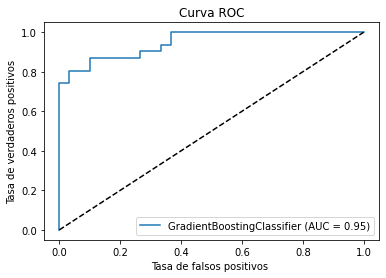

In [20]:
## Precision, Recall y F1-SCORE en validation

print(classification_report(y_val, gradient_b.predict(X_val)))             # Revisamos metricas

# Graficamos curva ROC
plot_roc_curve(gradient_b, X_val, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos ')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()
plt.show()

### Óptimización de hipeparametros y revisión de metricas luego de optimizar

In [0]:
parameters = {"loss":["deviance"],   
              "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
              "min_samples_split": np.linspace(0.1, 0.5, 12),
              "min_samples_leaf": np.linspace(0.1, 0.5, 12),
              "max_depth":[3,5,8],
              "max_features":["log2","sqrt"],    
              "criterion": ["friedman_mse",  "mae"],
              "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],    
              "n_estimators":[10]    }

gradient_b_2 = GridSearchCV(gradient_b, parameters, cv=5, n_jobs=-1)

In [0]:
gradient_b_2.fit(X_train, y_train)   

### Metricas de clasificación despues de optimización 

In [0]:
## Metrica Accuracy en train, val y test,

# Desempeño en entrenamiento
print('El desempeño del gradient Boosting en train es de', accuracy_score(y_train, gradient_b_2.predict(X_train)))

# Desempeño en val
print('El desempeño del gradient Boosting en validacion es de', accuracy_score(y_val, gradient_b_2.predict(X_val)))

# Desempeño en test 
print('El desempeño del gradient Boosting en test es de', accuracy_score(y_test, gradient_b_2.predict(X_test)))

In [0]:
# Precision, recall y f1-scores en validation
print(classification_report(y_val, gradient_b_2.predict(X_val))) 